Epoch 0 — Loss: 3.5016, Val Loss: 3.4965, Train Acc: 0.0310, Val Acc: 0.0296
Epoch 10 — Loss: 3.4986, Val Loss: 3.4917, Train Acc: 0.0644, Val Acc: 0.0603
Epoch 20 — Loss: 2.7188, Val Loss: 2.6362, Train Acc: 0.2050, Val Acc: 0.2058
Epoch 30 — Loss: 1.5792, Val Loss: 1.5603, Train Acc: 0.5220, Val Acc: 0.5216
Epoch 40 — Loss: 0.9932, Val Loss: 1.0201, Train Acc: 0.6976, Val Acc: 0.6837
Epoch 50 — Loss: 0.6334, Val Loss: 0.7010, Train Acc: 0.8097, Val Acc: 0.7838
Epoch 60 — Loss: 0.4358, Val Loss: 0.5471, Train Acc: 0.8677, Val Acc: 0.8282
Epoch 70 — Loss: 0.3199, Val Loss: 0.4611, Train Acc: 0.9016, Val Acc: 0.8547
Epoch 80 — Loss: 0.2426, Val Loss: 0.3827, Train Acc: 0.9382, Val Acc: 0.8805
Epoch 90 — Loss: 0.1880, Val Loss: 0.3719, Train Acc: 0.9407, Val Acc: 0.8815
Epoch 100 — Loss: 0.1491, Val Loss: 0.3271, Train Acc: 0.9635, Val Acc: 0.8980

Classification Report:
              precision    recall  f1-score   support

          ya       0.95      0.95      0.95        43
         

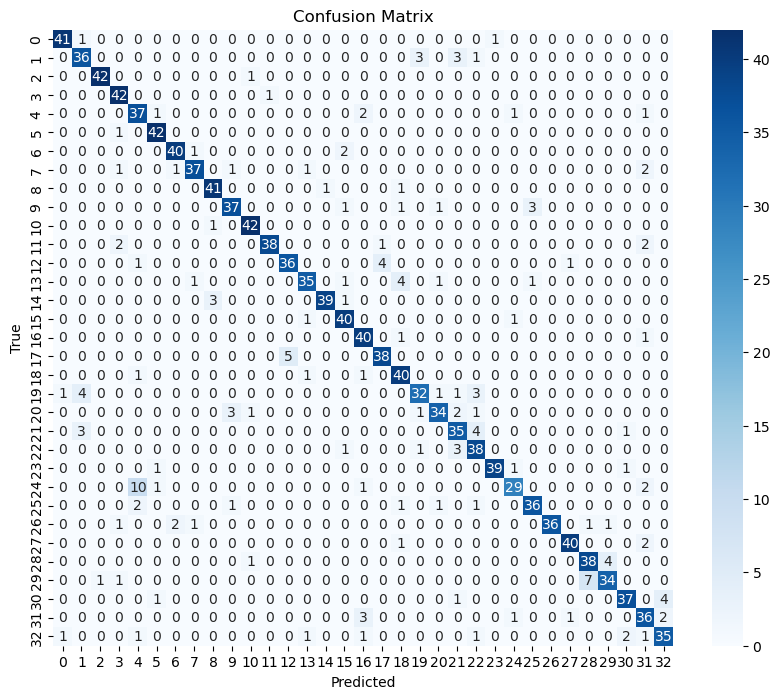

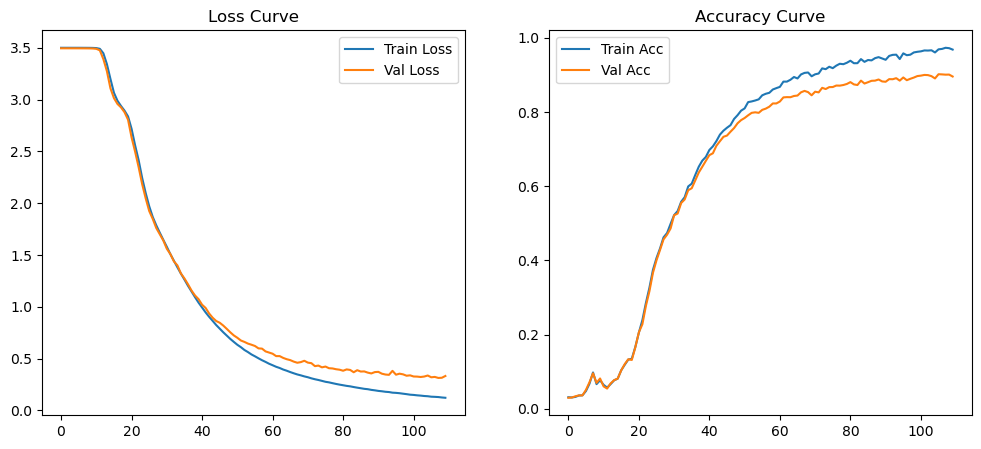

In [44]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Activation Functions ---
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# --- MLP Class ---
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_sizes[i+1])))

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z)
        output = softmax(z)
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def compute_accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [None] * len(self.weights)
        self.d_biases = [None] * len(self.biases)
        dZ = outputs - y
        self.d_weights[-1] = self.activations[-2].T @ dZ / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in reversed(range(len(self.weights) - 1)):
            dZ = (dZ @ self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = self.activations[i].T @ dZ / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs=100, batch_size=32):
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[indices], y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            train_pred = self.forward(X)
            val_pred = self.forward(X_val)
            train_losses.append(epoch_loss / (X.shape[0] // batch_size))
            val_losses.append(self.compute_loss(y_val, val_pred))
            train_accuracies.append(self.compute_accuracy(y, train_pred))
            val_accuracies.append(self.compute_accuracy(y_val, val_pred))
            if epoch % 10 == 0:
                print(f"Epoch {epoch} — Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
                      f"Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)

# --- Image Processing & Dataset ---
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img.flatten()

# Adapt paths here as needed
data_dir = 'amhcd-data-64/tifinagh-images'
image_paths, labels = [], []
for label_dir in os.listdir(data_dir):
    for img_name in os.listdir(os.path.join(data_dir, label_dir)):
        image_paths.append(os.path.join(data_dir, label_dir, img_name))
        labels.append(label_dir)
labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
X = np.array([load_and_preprocess_image(p) for p in labels_df['image_path']])
y = labels_df['label_encoded'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)
one_hot = OneHotEncoder(sparse_output=False)
y_train_oh = one_hot.fit_transform(y_train.reshape(-1, 1))
y_val_oh = one_hot.transform(y_val.reshape(-1, 1))
y_test_oh = one_hot.transform(y_test.reshape(-1, 1))

# --- Model Training ---
input_dim = X_train.shape[1]
num_classes = y_train_oh.shape[1]
model = MultiClassNeuralNetwork([input_dim, 64, 32, num_classes])
train_losses, val_losses, train_accs, val_accs = model.train(X_train, y_train_oh, X_val, y_val_oh, epochs=110)

# --- Evaluation ---
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix Plot ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')

# --- Loss/Accuracy Curves ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")
plt.savefig('training_curves.png')
